<div class="alert alert-danger">
It is recommended to run this notebook on a GPU
</div>

In [1]:
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
plt.style.use(["seaborn-deep", "seaborn-whitegrid"])

# Generative Adversarial Networks

Generative Adversarial Networks (GAN) [[Goodfellow, 2014]](https://arxiv.org/abs/1406.2661) have recently become a popular alternative to variational autoencoders for generative modelling and to a lesser extend semi-supervised learning. They also represent the state-of-the-art in modelling of realistic images and video just four years after their introduction. Below you can see a comparison of the development in GANs for generation of realistic faces from 2014 until today.

<img src="../static_files/GAN-celebA.jpg" alt="GAN performance over the years" width="600px"/>

Different variants of GANs have also proven to perform well on tasks such inpainting, super-resolution and image-to-image translation. In this notebook we will again work with a subset of the MNIST-dataset in order to compare with VAEs.

In [22]:
import torch
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce

# The digit classes to use, these need to be in order because
# we are using one-hot representation
# classes = np.arange(2)
classes = np.arange(7)

def one_hot(labels):
    y = torch.eye(len(classes)) 
    return y[labels]

# Define the train and test sets
dset_train = MNIST("./", train=True, download=True, transform=ToTensor(), target_transform=one_hot)
dset_test  = MNIST("./", train=False, transform=ToTensor(), target_transform=one_hot)

def stratified_sampler(labels):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)


batch_size = 64
# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.train_labels), pin_memory=cuda)
test_loader  = DataLoader(dset_test, batch_size=batch_size, 
                          sampler=stratified_sampler(dset_test.test_labels), pin_memory=cuda)

F:\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
F:\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


# Adversarial learning

The training process of a GAN can be seen as a two player game involving a discriminator network ($D$) and a generator network($G$). Intuitively, we can describe the role of the two networks as "police" and "forger", respectively. Given some empirical distribution $p(x)$, the forger wants to fool the police by creating samples that look like they come from $p(x)$. The police will then try to "analayse each art piece" to guess whether it is forged or not. This process leads the generator to eventually generate samples that are indistinguishable from the real data.

<img src="../static_files/GAN.png" alt="GAN diagram" width="500px"/>

Below we define a deep convolutional generative adversarial network (DCGAN), introduced by [[Radford, 2015]](https://arxiv.org/abs/1511.06434). This means that both the discriminator and generator are deep convolutional networks.

In [23]:
from torch import nn

latent_dim = 10

# The generator takes random `latent` noise and
# turns it into an MNIST image.
generator = nn.Sequential(
    # nn.ConvTranspose2d can be seen as the inverse operation
    # of Conv2d, where after convolution we arrive at an
    # upscaled image.
    nn.ConvTranspose2d(latent_dim, 256, kernel_size=3, stride=2),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),
    nn.Sigmoid() # Image intensities are in [0, 1]
).to(device)

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

# The discriminator takes an image (real or fake)
# and decides whether it is generated or not.
discriminator = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=4, stride=2),
    nn.LeakyReLU(0.2),
    nn.Conv2d(64, 128, kernel_size=4, stride=2),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2),
    nn.Conv2d(128, 256, kernel_size=4, stride=2),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2),
    Flatten(),
    nn.Linear(256, 1),
    nn.Sigmoid()
).to(device)

loss = nn.BCELoss()
print("Using device:", device)

generator_optim = torch.optim.Adam(generator.parameters(), 2e-4, betas=(0.5, 0.999))
discriminator_optim = torch.optim.Adam(discriminator.parameters(), 2e-4, betas=(0.5, 0.999))

Using device: cuda:0


## The GAN game

The objective function can be formulated within the framework of game-theory, concretely as a zero-sum game. The optimum is therefore given by the *Nash equilibrium* between $D$ and $G$. Unfortunately, there exists no such algorithm capable of finding the Nash equilibrium directly, so we must instead resort to gradient descent, for which we arrive at the following objective function $V(D, G)$.

$$\min_{G}\max_{D} V(D, G) = \mathbb{E}_{x \sim p(x)} [\log D(x)] + \mathbb{E}_{z \sim p(z)} [\log(1 - D(G(z)))]$$

Where $x \sim p(x)$ is sampled from the true distribution and $z \sim p(z)$ is a sample from the noise distribution. To break down this objective we consider the first term $\max_{D}\mathbb{E}_{x \sim p(x)} [\log D(x)]$, which is the log-likelihood of the discriminator correctly classifying a data point as coming from the true distribution. The second term $\min_{G}\max_{D} \mathbb{E}_{z \sim p(z)} [\log(1 - D(G(z)))]$ can be seen as a dual objective of the discriminator correctly rejecting a sample from the generator by maximising the likelihood, while simultaneously, the generator should minimise the chance of being "caught" by the discriminator.

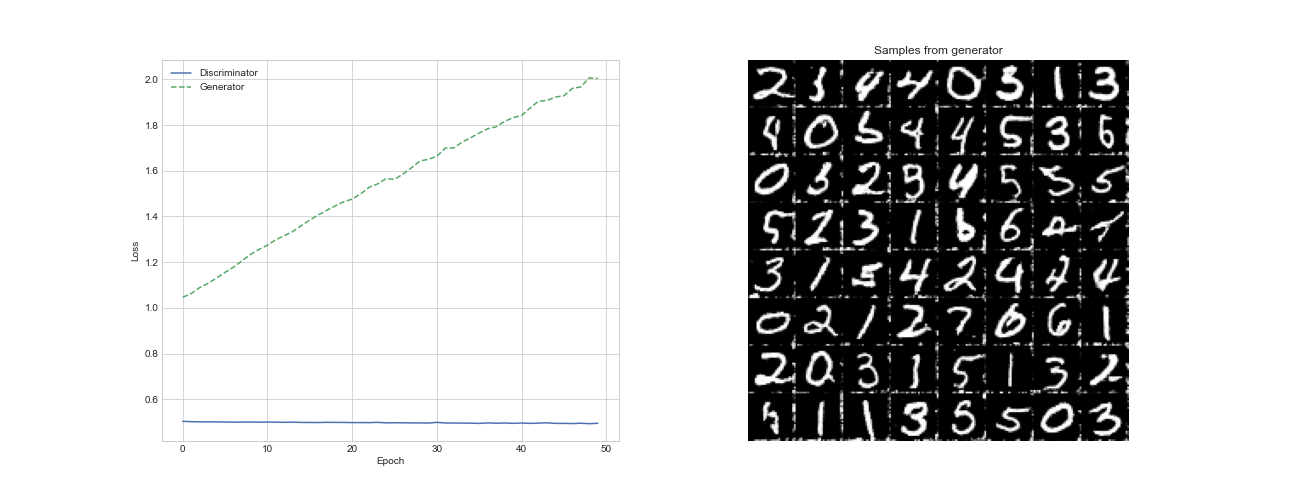

In [25]:
from torch.autograd import Variable
import os

tmp_img = "tmp_gan_out.png"
discriminator_loss, generator_loss = [], []

num_epochs = 50
for epoch in range(num_epochs):
    batch_d_loss, batch_g_loss = [], []
    
    for x, _ in train_loader:
        batch_size = x.size(0)
        # True data is given label 1, while fake data is given label 0
        true_label = torch.ones(batch_size, 1).to(device)
        fake_label = torch.zeros(batch_size, 1).to(device)
        
        discriminator.zero_grad()
        generator.zero_grad()
        
        # Step 1. Send real data through discriminator
        #         and backpropagate its errors.
        x_true = Variable(x).to(device)        
        output = discriminator(x_true)
        
        error_true = loss(output, true_label)
        error_true.backward()
        
        # Step 2. Generate fake data G(z), where z ~ N(0, 1)
        #         is a latent code.
        z = torch.randn(batch_size, latent_dim, 1, 1)
        z = Variable(z, requires_grad=False).to(device)
        
        x_fake = generator(z)
            
        # Step 3. Send fake data through discriminator
        #         propagate error and update D weights.
        # --------------------------------------------
        # Note: detach() is used to avoid compounding generator gradients
        output = discriminator(x_fake.detach()) 
        
        error_fake = loss(output, fake_label)
        error_fake.backward()
        discriminator_optim.step()
        
        # Step 4. Send fake data through discriminator _again_
        #         propagate the error of the generator and
        #         update G weights.
        output = discriminator(x_fake)
        
        error_generator = loss(output, true_label)
        error_generator.backward()
        generator_optim.step()
        
        batch_d_loss.append((error_true/(error_true + error_fake)).item())
        batch_g_loss.append(error_generator.item())

    discriminator_loss.append(np.mean(batch_d_loss))
    generator_loss.append(np.mean(batch_g_loss))
    
    # -- Plotting --
    f, axarr = plt.subplots(1, 2, figsize=(18, 7))

    # Loss
    ax = axarr[0]
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

    ax.plot(np.arange(epoch+1), discriminator_loss)
    ax.plot(np.arange(epoch+1), generator_loss, linestyle="--")
    ax.legend(['Discriminator', 'Generator'])
    
    # Latent space samples
    ax = axarr[1]
    ax.set_title('Samples from generator')
    ax.axis('off')

    rows, columns = 8, 8
    
    # Generate data
    with torch.no_grad():
        z = torch.randn(rows*columns, latent_dim, 1, 1)
        z = Variable(z, requires_grad=False).to(device)
        x_fake = generator(z)
    
    canvas = np.zeros((28*rows, columns*28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_fake.data[idx].cpu()
    ax.imshow(canvas, cmap='gray')
    
    plt.savefig(tmp_img)
    plt.close(f)
    display(Image(filename=tmp_img))
    clear_output(wait=True)

    os.remove(tmp_img)

# Assignments


## Assignment 1 - Analyzing the GAN
* Reduce the latent space dimension, is the generator still able to create convincing samples? Give an explanation for what you see (*hint: think of the generator as the inverse of a non-linear PCA*).
* Try training the GAN a couple of times using different digits and latent space dimension; does training always converge? If it doesn't, what happens?
* Consider the case when the generator is perfect, effectively meaning that any sample from $G(z)$ is indistinguishable from a sample from the true distribution. What is then the value $D(x)$ for any $x$? Is this value an optimum?

## Optional assignment 2 - Conditional GANs
Take a look at conditional GANs [[Mirza and Osindero, 2014]](https://arxiv.org/abs/1411.1784). In essence, we add additional information through the variable $y$ to the GAN

* Assume that the following about the mutual information between $X$ and $Y$: $I(X, Y) > 0$. Now prove that knowing $Y$ reduces our uncertainty about $X$, equivalently $H(X|Y) \leq H(X)$. Explain why this makes the GAN better.
* Explain how a conditional GAN can be used for semi-supervised learning. How would you formulate the objective (loss) function?
* Implement a conditional GAN by feeding in the label information for each digit into the generator and discriminator. You can use the code below as a starting point.

In [26]:
# Because of the information bottleneck, with a lower latent space dimension, the generator is not able to create convincing samples. 
# It does not always converge. Gradient Vainishing. The generator loss tends to increase all the way. 
# It shall be 1. It's not an optimum, maybe overfitting. 

In [27]:
from torch import nn

latent_dim = 100
label_dim = len(classes)

# The generator takes random `latent` noise and
# a label it into an MNIST image conditioned on label
# p(x|y).
class ConditionalGenerator(nn.Module):
    def __init__(self):
        super(ConditionalGenerator, self).__init__()
        
        self.conv_z = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=3, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        self.conv_y = nn.Sequential(
            nn.ConvTranspose2d(label_dim, 256, kernel_size=3, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.model = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )
        
    def forward(self, x, y):
        # Merge information and send through network.
        x = torch.cat([?, ?], dim=1)
        x = self.model(x)
        return x


class ConditionalDiscriminator(nn.Module):
    def __init__(self):
        super(ConditionalDiscriminator, self).__init__()
        self.conv_x = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2),
            nn.LeakyReLU(0.2)
        )
        
        self.conv_y = nn.Sequential(
            nn.Conv2d(label_dim, 64, kernel_size=4, stride=2),
            nn.LeakyReLU(0.2)
        )
        
        self.model = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            Flatten(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, y):
        # Merge information and send through network.
        x = torch.cat([?, ?], dim=1)
        x = self.model(x)
        return x

loss = nn.BCELoss()
print("Using device:", device)

generator = ConditionalGenerator().to(device)
discriminator = ConditionalDiscriminator().to(device)

generator_optim = torch.optim.Adam(generator.parameters(), 2e-4, betas=(0.5, 0.999))
discriminator_optim = torch.optim.Adam(discriminator.parameters(), 2e-4, betas=(0.5, 0.999))

SyntaxError: invalid syntax (<ipython-input-27-6240422fd213>, line 38)

In [ ]:
for epoch in range(num_epochs):    
    for x, y in train_loader:
        batch_size = x.size(0)
        # True data is given label 1, while fake data is given label 0
        true_label = torch.ones(batch_size, 1).to(device)
        fake_label = torch.zeros(batch_size, 1).to(device)

        x_true = Variable(x).to(device)
        y = Variable(y).to(device)
        
        # Create random noise
        z = torch.randn(batch_size, latent_dim, 1, 1)
        z = Variable(z, requires_grad=False).to(device)
        
        # --- Define you training here ---